# Part 4: 

This notebook will serve to format the tweet data (cleaned in the `data_cleaning.ipynb` notebook) into a tf-idf structure and then perform topic modeling via NMF and LDA.

### General setup

In [1]:
# Import packages
import pandas as pd 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

In [2]:
# Set theme for creating visualizations

# Set text sizes
title_size = 22
label_size = 16
tick_text_size = 12

# Set background and text colors
background_color = '#F7F7F4'
text_color = 'black'

# Set options of colors for use in plotting
color1 = "#9FB881"  # (dark green)
color2 = "#B89A81"  # (brown)
color3 = "#2E4057"  # (charcoal)
color4 = "#cfbaa9"  # (light brown)
color5 = "#806248"  # (dark brown)
color6 = "#B8B681"  # (dark tan)
color7 = "#D19C1D"  # (gold)
color8 = "#969966"  # (army green)

# Set theme for creating visualizations
plt.rcParams.update({
                     'axes.edgecolor': 'white',
                     'axes.facecolor': background_color,
                     'axes.grid': True,
                     'axes.labelcolor': text_color,
                     'axes.titlesize': title_size,
                     'axes.labelsize': label_size,
                     'figure.facecolor': background_color,
                     'text.color': text_color,
                     'xtick.color': text_color,
                     'xtick.labelsize' : tick_text_size,
                     'ytick.color': text_color,
                     'ytick.labelsize' : tick_text_size,
                     })

### Prepare data

In [3]:
# Read in data
data = pd.read_csv('./cleaned_tweet_data.csv')

# View first few rows of data
data.head(2)

,created_at,text,hashtags,user_mention_ids,user_mention_screen_names,retweet_count,favorite_count,user_id,user_screen_name,user_name,user_location,user_friends_count,user_followers_count,user_favourites_count,user_verfied,user_statuses_count,topic,text_clean,text_clean_noStop,text_clean_noStop_noSearch
0,2022-10-18 00:00:00,Sharp words on guns in Shane Hazel to Stacey A...,['gagovdebate'],[],[],5,24,25282846,SimonesNews,Simone Sebastian,Washington DC,3110,5830,1445,True,4400,abrams,sharp words on guns in shane hazel to stacey ...,sharp words guns shane hazel stacey abrams kee...,sharp words guns shane hazel keep going back g...
1,2022-10-18 00:00:01,Stacey Abrams won tonight. She kept to the fac...,[],[],[],0,6,1312393604439183361,nching0,Thee Lost Edges of Candace 🪥,"34.2073° N, 84.1402° W",922,752,101529,False,61963,abrams,stacey abrams won tonight she kept to the fa...,stacey abrams tonight kept facts answered ques...,tonight kept facts answered questions math poi...


In [4]:
### Make new column with all search words except for 'abrams' and 'kemp' removed

# Define search words used in collecting tweets 
search_words = ['georgia', 'governor', 'gov', 'election', 'ga',
                'brian', 'kemps', 'briankemp',
                'stacey', 'staceyabrams', 'abramss',
                'nominee', 'candidate', 'incumbent']

# Define method to lowercase and remove stopwords and search words from tweet
def remove_searchwords(tweet):
    tweet = [word for word in tweet.split() if word not in search_words]
    tweet = ' '.join(tweet)
    return tweet

# Apply method to text_clean_noStop column
no_search = []
for tweet in list(data['text_clean_noStop']):
    if isinstance(tweet, float) == False:
        tweet = remove_searchwords(tweet)
    no_search.append(tweet)
data['text_clean_noStop_noSearch'] = no_search

# View first few rows of text and cleaned text columns
data[['text', 'text_clean', 'text_clean_noStop', 'text_clean_noStop_noSearch']].head(10)

,text,text_clean,text_clean_noStop,text_clean_noStop_noSearch
0,Sharp words on guns in Shane Hazel to Stacey A...,sharp words on guns in shane hazel to stacey ...,sharp words guns shane hazel stacey abrams kee...,sharp words guns shane hazel abrams keep going...
1,Stacey Abrams won tonight. She kept to the fac...,stacey abrams won tonight she kept to the fa...,stacey abrams tonight kept facts answered ques...,abrams tonight kept facts answered questions m...
2,"Why did Joe Rogan send his little brother, Sha...",why did joe rogan send his little brother shan...,joe rogan send little brother shane interrupt ...,joe rogan send little brother shane interrupt ...
3,Viral handbag designer and EBONY Power100 Styl...,viral handbag designer and ebony power style c...,viral handbag designer ebony power style curat...,viral handbag designer ebony power style curat...
4,THE MOST DANGEROUS THING FACING GEORGIA IS 4 M...,the most dangerous thing facing georgia is mor...,dangerous thing facing georgia years brian kem...,dangerous thing facing years kemp wow
5,Mrs. Abrams showed the same poise and skill as...,mrs abrams showed the same poise and skill a...,mrs abrams showed poise skill kbj earlier year...,mrs abrams showed poise skill kbj earlier year...
6,Thanks for the link BDD! Who was the other guy...,thanks for the link bdd who was the other guy ...,thanks link bdd guy seems lot like republicans...,thanks link bdd guy seems lot like republicans...
7,"Stacey Abrams: ""The most dangerous thing facin...",stacey abrams the most dangerous thing facin...,stacey abrams dangerous thing facing georgia f...,abrams dangerous thing facing four years kemp ...
8,"Stacey Abrams is on ,",stacey abrams is on,stacey abrams,abrams
9,Yeah . But they dont have to . If he told them...,yeah but they dont have to if he told them not...,yeah dont told vote brian kemp still would hes...,yeah dont told vote kemp still would hes got b...


In [5]:
# Subset data to keep only the cleaned text data with no stopwords
data_noStop = data[['text_clean_noStop_noSearch', 'topic']]

# Rename column
data_noStop.rename(columns={'text_clean_noStop_noSearch':'text_clean'}, inplace=True)

# Remove any tweets that have no words after cleaning + removing stopwords
data_noStop = data_noStop[~data_noStop['text_clean'].isna()]

# See first few rows of updated dataframe
data_noStop.head(10)

/var/folders/tj/b8x6sk5104794yn7q0kw1wbm0000gn/T/ipykernel_1137/2595766477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noStop.rename(columns={'text_clean_noStop_noSearch':'text_clean'}, inplace=True)


,text_clean,topic
0,sharp words guns shane hazel abrams keep going...,abrams
1,abrams tonight kept facts answered questions m...,abrams
2,joe rogan send little brother shane interrupt ...,abrams
3,viral handbag designer ebony power style curat...,abrams
4,dangerous thing facing years kemp wow,kemp
5,mrs abrams showed poise skill kbj earlier year...,kemp
6,thanks link bdd guy seems lot like republicans...,abrams
7,abrams dangerous thing facing four years kemp ...,"abrams, kemp"
8,abrams,abrams
9,yeah dont told vote kemp still would hes got b...,kemp


In [6]:
# Subset data to keep only the cleaned text data with no stopwords + no search words
data_noSearch = data[['text_clean_noStop_noSearch', 'topic']]

# Rename column
data_noSearch.rename(columns={'text_clean_noStop_noSearch':'text_clean'}, inplace=True)

# Remove any tweets that have no words after cleaning + removing stopwords + removing search words
data_noSearch = data_noSearch[~data_noSearch['text_clean'].isna()]

# See first few rows of updated dataframe
data_noSearch.head(10)

/var/folders/tj/b8x6sk5104794yn7q0kw1wbm0000gn/T/ipykernel_1137/4005527159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noSearch.rename(columns={'text_clean_noStop_noSearch':'text_clean'}, inplace=True)


,text_clean,topic
0,sharp words guns shane hazel abrams keep going...,abrams
1,abrams tonight kept facts answered questions m...,abrams
2,joe rogan send little brother shane interrupt ...,abrams
3,viral handbag designer ebony power style curat...,abrams
4,dangerous thing facing years kemp wow,kemp
5,mrs abrams showed poise skill kbj earlier year...,kemp
6,thanks link bdd guy seems lot like republicans...,abrams
7,abrams dangerous thing facing four years kemp ...,"abrams, kemp"
8,abrams,abrams
9,yeah dont told vote kemp still would hes got b...,kemp


### Split tweets into those about Abrams and those about Kemp

In [7]:
# Split dataframe into tweets about abrams and tweets about kemp
data_noStop_abrams = data_noStop[data_noStop['topic'].str.contains('abrams')]
data_noStop_kemp = data_noStop[data_noStop['topic'].str.contains('kemp')]
data_noSearch_abrams = data_noSearch[data_noSearch['topic'].str.contains('abrams')]
data_noSearch_kemp = data_noSearch[data_noSearch['topic'].str.contains('kemp')]

Wordclouds are made for the two dataframes to see the difference of word usage between the two topics.

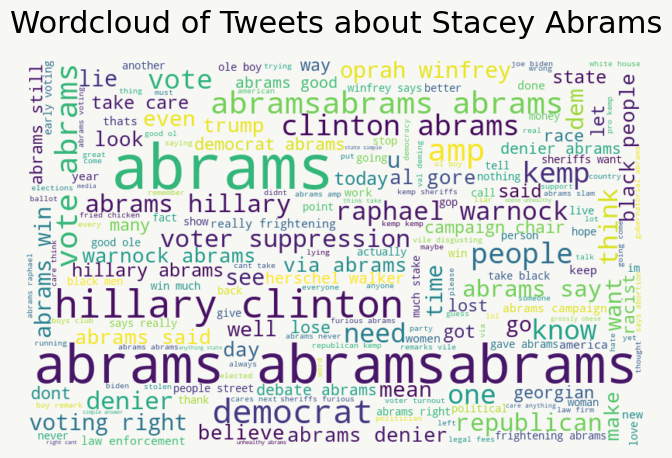

In [8]:
# Get all words used in tweets about Abrams
abrams_words = ' '.join([word for word in data_noStop_abrams['text_clean']]) 

# Make wordcloud from words used in tweets about Abrams
wordcloud_abrams = WordCloud(width=800, 
                             height=500, 
                             random_state=26, 
                             max_font_size=80, 
                             background_color=background_color).generate(abrams_words) 
fig, ax = plt.subplots(1,1, figsize=(8, 6)) 
plt.imshow(wordcloud_abrams, interpolation="bilinear") 
plt.axis('off')
ax.set_title('Wordcloud of Tweets about Stacey Abrams', color='black', pad=20)
plt.savefig('../Visualizations/abrams_wordcloud.png')
plt.show()

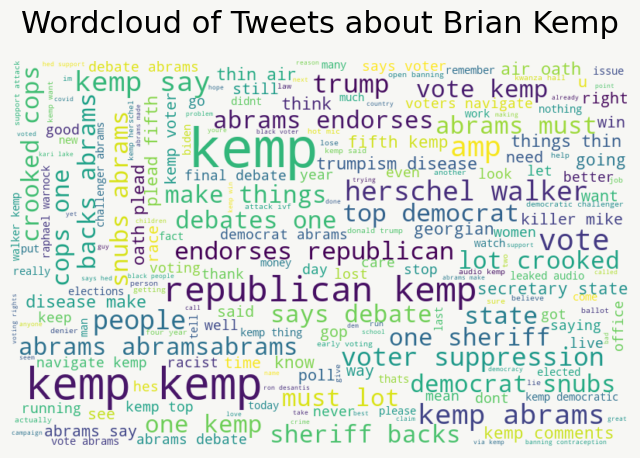

In [9]:
# Get all words used in tweets about Kemp
kemp_words = ' '.join([word for word in data_noStop_kemp['text_clean']]) 

# Make wordcloud from words used in tweets about Abrams
wordcloud_kemp = WordCloud(width=800, 
                           height=500, 
                           random_state=26, 
                           max_font_size=70,
                           background_color=background_color).generate(kemp_words) 
fig, ax = plt.subplots(1,1, figsize=(8, 6)) 
plt.imshow(wordcloud_kemp, interpolation="bilinear") 
plt.axis('off')
ax.set_title('Wordcloud of Tweets about Brian Kemp', color='black', pad=20)
plt.savefig('../Visualizations/kemp_wordcloud.png')
plt.show()

### Word2Vec modeling  

**All Tweets**

In [10]:
# Tokenize the tweet text
tweet_tokens_all = data_noStop['text_clean'].apply(lambda x: x.split()) 

# Make word2vec model and train on data
mod_w2v_all = gensim.models.Word2Vec(tweet_tokens_all,
                                     window=5,
                                     min_count=2,
                                     sg = 1, # skip-gram model
                                     hs = 0,
                                     negative = 10,
                                     workers= 32,
                                     seed = 34
                                     ) 
mod_w2v_all.train(tweet_tokens_all, total_examples=len(data_noStop['text_clean']), epochs=20)

(10300589, 11962720)

In [11]:
similarity_abrams = [word for (word, value) in mod_w2v_all.wv.most_similar(positive='abrams')]
similarity_kemp = [word for (word, value) in mod_w2v_all.wv.most_similar(positive='kemp')]

print('Most Similar Words to "Abrams":', similarity_abrams)
print('Most Similar Words to "Kemp":', similarity_kemp)

Most Similar Words to "Abrams": ['kemp', 'narrator', 'isdisgusting', 'yesdon', 'yesfor', 'bailing', 'hellyes', 'abortionist', 'beyonc', 'paging']
Most Similar Words to "Kemp": ['abrams', 'jezebel', 'mostgeorgia', 'essence', 'tacitly', 'rgeorgiasenate', 'topgeorgiadem', 'insinuate', 'hes', 'squirrel']


**Abrams Tweets**

In [12]:
# Tokenize the tweet text
tweet_tokens_abrams = data_noStop_abrams['text_clean'].apply(lambda x: x.split()) 

# Make word2vec model and train on data
mod_w2v_abrams = gensim.models.Word2Vec(tweet_tokens_abrams,
                                        window=5,
                                        min_count=2,
                                        sg = 1, # skip-gram model
                                        hs = 0,
                                        negative = 10,
                                        workers= 32,
                                        seed = 34
                                        ) 
mod_w2v_abrams.train(tweet_tokens_abrams, total_examples=len(data_noStop_abrams['text_clean']), epochs=20)

(6738302, 7970340)

In [13]:
# Get most similar words for 'abrams' and 'kemp' from Abrams tweets
similarity_AbramsTweets_abrams = [word for (word, value) in mod_w2v_abrams.wv.most_similar(positive='abrams')]
similarity_AbramsTweets_kemp = [word for (word, value) in mod_w2v_abrams.wv.most_similar(positive='kemp')]

# View results
print('Most Similar Words to "abrams" from Tweets about Abrams:', similarity_AbramsTweets_abrams)
print('Most Similar Words to "kemp" from Tweets about Kemp:', similarity_AbramsTweets_kemp)

Most Similar Words to "abrams" from Tweets about Abrams: ['votenoon', 'anogo', 'yesfor', 'relax', 'narrator', 'misspelled', 'denyer', 'yesdon', 'thennoone', 'paging']
Most Similar Words to "kemp" from Tweets about Kemp: ['swarmed', 'foxnews', 'challengers', 'lawmaker', 'trails', 'contestants', 'sample', 'carlyjae', 'memorable', 'renew']


**Brian Kemp**

In [14]:
# Tokenize the tweet text
tweet_tokens_kemp = data_noStop_kemp['text_clean'].apply(lambda x: x.split()) 

# Make word2vec model and train on data
mod_w2v_kemp = gensim.models.Word2Vec(tweet_tokens_kemp,
                                      window=5,
                                      min_count=2,
                                      sg = 1, # skip-gram model
                                      hs = 0,
                                      negative = 10,
                                      workers= 32,
                                      seed = 34
                                      ) 
mod_w2v_kemp.train(tweet_tokens_kemp, total_examples=len(data_noStop_kemp['text_clean']), epochs=20)

(3136666, 3821660)

In [15]:
# Get most similar words for 'abrams' and 'kemp' from Kemp tweets
similarity_KempTweets_abrams = [word for (word, value) in mod_w2v_kemp.wv.most_similar(positive='abrams')]
similarity_KempTweets_kemp = [word for (word, value) in mod_w2v_kemp.wv.most_similar(positive='kemp')]

# View results
print('Most Similar Words to "abrams" from Tweets about Kemp:', similarity_KempTweets_abrams)
print('Most Similar Words to "kemp" from Tweets about Kemp:', similarity_KempTweets_kemp)

Most Similar Words to "abrams" from Tweets about Kemp: ['kemp', 'web', 'debate', 'ohsnap', 'newsweek', 'nbcnews', 'nothin', 'newsworldpress', 'mondays', 'contestants']
Most Similar Words to "kemp" from Tweets about Kemp: ['abrams', 'one', 'tyson', 'ohsnap', 'sayin', 'salad', 'yes', 'dino', 'scoontv', 'slam']
